## Analysis of A/B Test Results

#### By Mathew Alton

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Resources and credit](#creds)
<br>
- [**review changelog 1 - observed difference**](#1)
- [**review changelog 2 - z tests**](#2)
- [**review changelog 3 - one-tail vs regression**](#3)


<a id='intro'></a>
### Introduction

This report is an analysis of an A/B test run by an anonymous e-commerce website. The aim of this report is to help this company understand whether they should implement a new web page, keep the old page, or run the experiment longer to make a more informed decision.

<a id='probability'></a>
#### Part I - Probability

To analyze the results of the A/B test effectively, a variety of different modules will be imported to make data analysis in Python easier. These modules include:

<ul>
  <li>Pandas - for the creation and manipulation of dataframes</li>
  <li>Numpy - for advanced mathematical functions</li>
  <li>Random - to ensure pseudo-random values are consistent</li>
  <li>Statsmodels.api - for regression analysis</li>
  <li>matplotlib - for visualizing data with graphs</li>
</ul>

> The magic command <b>%matplotlib inline</b> is also declared so that graphs can be viewed inline with the content of this report

In [1]:
# module aliases will be used to reduce line count.
# examples include pd (pandas) and np (numpy)

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

# magic command; allows graphs to be plotted inline
%matplotlib inline

# random seed is set to 42 for consistency
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


By importing the <b>Pandas module</b>, a function that can read in large .csv files and convert them into mutable dataframes is now available:<b>pd.read_csv</b>.

>For this particular A/B analysis, the <b>ab.data.csv</b> file will be imported and stored in the <b>df</b> dataframe

For verification, the <b>df.head(5)</b> command will output the first 5 values from the newly created <b>df</b> dataframe:

In [2]:
# store the contents of 'ab_data.csv' in the df dataframe
df = pd.read_csv('ab_data.csv')

# output the first five values in the df dataframe
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


For a better understanding of the number of rows/columns in the <b>df</b> dataframe, the <b>df.info()</b> function will be used:

In [3]:
# lists the total number of dataframe entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


By default, the <b>df</b> dataframe contains 5 columns and 294478 rows--which suggests that there is a <b>population size of 294478</b>. 

But this function does not take duplicate entries into account; it simply counts the number of rows/columns and not unique IDs in the data set.

>To determine the number of <i>unique</i> IDs in the data set--and thus ascertain the real population size--the <b>nunique()</b> function can be leveraged as below:

In [4]:
# stores the no. of unique IDs in the unique_users variable
unique_users = df.user_id.nunique()

# prints the value of the unique_users variable
print(unique_users)

290584


By counting the total number of unique user IDs in the dataframe and storing them in the <b>unique_users</b> variable, it is clear that there are extraneous entries in the data set: <b>there are only 290584 unique entries compared to the total recorded population of 294478.</b>

Through the use of variables and Pandas, the total number of unique page conversions from unique user IDs can still be stored without deleting values from the data set:

>The variable <b>converted_users</b> will store every unique ID that succesfully converted pages, as expressed below:

In [5]:
# filters the df dataframe by unique user IDs
# stores user IDs with a conversion value of 1 (success)

converted_users = df[df.converted == 1]['user_id'].nunique()

To calculate the proportion of <i>unique users</i> who successfully converted, the following equation will be used:

>$P = x / n$

Where:

<ul>
  <li>P = proportion</li>
  <li>x = the number of conversions</li>
  <li>n = the population (290584)</li>
</ul>

In [6]:
# the proportion variable stores this equation
proportion = (converted_users / unique_users)

print(proportion)

0.12104245244060237


From the equation above, it can be observed that <b>12% of total (unique) users converted</b>.

The A/B test can be summarized as follows:

<ul>
    <li><b>new pages</b> are distributed to the <b>treatment</b> group of users</li>
    <li><b>old pages</b> are distributed to the <b>control</b> group of     users</li>
</ul>

One possible explanation for the presence of duplicated user_IDs values in the data set may stem from <b>users receiving pages in error</b>: a treatment user receiving an old page, or a control user receiving a new page etc.

>To determine whether this is the case, the <b>groupby</b> function will be used to explore whether there was a discrepancy in how pages were delivered to certain user groups:

In [7]:
# credit: https://bit.ly/2l2rxBG

# groups the dataframe by the landing_page and group columns
# the size() function is then used to display value counts 
# the value is stored in the the group_counts2 variable

group_counts1 = df.groupby(['landing_page', 'group']).size()

print(group_counts1)

landing_page  group    
new_page      control        1928
              treatment    145311
old_page      control      145274
              treatment      1965
dtype: int64


>An alternative approach would be to use a <b>crosstab</b>, as expressed below:

In [8]:
# creates a crosstab of landing_page and group columns
# the value is stored in the the group_counts2 variable

group_counts2 = pd.crosstab(df.landing_page, df.group)

print(group_counts2)

group         control  treatment
landing_page                    
new_page         1928     145311
old_page       145274       1965


The output(s) above suggest that there were <b>3893 pages received in error:</b>

<ul>
    <li>1928 in new page - control</li>
    <li>1965 in old page - treatment</li>
</ul>

As expressed earlier:

<ul>
    <li>Total population: <b>294478</b> </li>
    <li>Unique population: <b>290584</b></li>
</ul>

Subtracting 3893 from the total population equals <b>290585</b>, which suggests that removing these values <b>(and an additional 1 duplicated value)</b> may result in a cleaned data set:

In [9]:
# subtract 3893 from the total population
# store this value in the alt_population variable

alt_population = (df.user_id.count() - 3893)

print(alt_population)

290585


To ensure that there are no null (empty) fields in the data set, the <b>isnull()</b> function can be called:

In [10]:
# prints the sum of empty fields in the data set

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

As can be seen in the output above, <b>there are no null fields in this data set.</b>

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

To mitigate this, fields that meet the following conditions:

<ul>
    <li>treatment group - new page </li>
    <li>control group - old page</li>
</ul>

...Will be **split from the original dataframe (df) and merged into a new one (df2)**. The code below expresses how this is done:

In [11]:
# credit: https://bit.ly/2u8jpDM

# groups 'treatment' with 'new page'
# these values are stored in the new_group variable

new_group = df[(df['group'] == 'treatment') &\
               (df['landing_page'] == 'new_page')]

# groups 'control' with 'old page'
# these values are stored in the old_group variable

old_group = df[(df.group == 'control') &\
               (df.landing_page == 'old_page')]

# the all_groups variable features an array of both groups

all_groups = [new_group, old_group]

# df2 is a new dataframe that merges these values together
df2 = pd.concat(all_groups)

# the crosstab command is issued for verification
pd.crosstab(df2.landing_page, df2.group)

group,control,treatment
landing_page,,
new_page,0,145311
old_page,145274,0


The crosstab for the new dataframe--**df2**--validates that the incorrect group/landing page combinations have been removed.

This can further be proved through the initiation of the code below:

In [12]:
# Confirmation that the correct rows were removed - should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))\
    == False].shape[0]

0

By using the **count()** function, the total number of users in the newly created **df2** dataframe reads comes in at **290585; 1 more than is expected.**

In [13]:
# counts the population of the df2 dataframe

df2.user_id.count()

290585

There is a likelihood that the additional row being counted is a duplicate. To identify whether this is the case, the **duplicated()** function will be used--as expressed below:

In [14]:
# prints duplicated values in df2's 'user_id' column

df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


From this output, the following can be gleaned:

<ul>
    <li>user_id: 773192 is a duplicate </li>
    <li>this duplicate is located at index 2893</li>
</ul>

To remove this duplicated field while retaining the other values in df2, the **drop()** function can be used--as expressed below:

In [15]:
# drops the row at index 2893 from df2
# inplace = True ensures that it is removed 

df2.drop(2893, inplace = True)

For verification that the row has been dropped from the df2 dataframe, the **duplicated** function can be repeated again:

In [16]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted


Moreover, by removing the duplicated row it is now clear that **the total population of the df2 dataframe is 290584.**

In [17]:
# prints df2 entries

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


With a relatively 'clean' df2 dataframe, probabilities of conversion can be calculated:

a. The probability of an individual converting regardless of the page they receive is **11.96%**.

In [18]:
# outputs average conversion from the entire dataframe
# final result is stored in 'avg_conversion'

avg_conversion = df2.converted.mean()

print(avg_conversion)

0.119597087245


b. Given that an individual was in the `control` group, the probability they converted was **12.4%**.

In [19]:
# filters df2 by 'group == control'
# outputs the average conversion for this filter
# final result is stored in 'con_conversion'

con_conversion = df2.query('group == "control"')['converted'].mean()

print(con_conversion)

0.1203863045


c. Given that an individual was in the `treatment` group, the probability they converted was **11.88%**.

In [20]:
# filters df2 by 'group == treatment'
# outputs the average conversion for this filter
# final result is stored in 'treat_conversion'

treat_conversion = df2.query('group == "treatment"')['converted'].mean()

print(treat_conversion)

0.118808065515


d. The probability that an individual received the new page is **50%**.

In [21]:
# filters 'new page' entries in the 'landing_page' column
# stores these values in the new_page_group variable
# final result is stored in 'prob_np'

new_page_group = df2.query('landing_page == "new_page"')

# divides new pages with total user

prob_np = (new_page_group.user_id.nunique() / df2.user_id.nunique())

print(prob_np)

0.5000619442226688


From the results above, it is inconclusive as to whether a particular page results in more conversions; **there is a very small difference between the conversion rates of the control (12.04%) and treatment groups (11.88%)** despite there being a 50% chance of receiving the respective page.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses should be as follows:

$H_0: p_{new} - p_{old} \leq 0$

$H_1: p_{new} - p_{old} > 0$

<br>
Where:
<ul>
    <li>$H_0$ - null hypothesis </li>
    <li>$H_1$ - alternative hypothesis</li>
</ul>


<!--
https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols
-->

`2.` It is assumed that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

The sample size for each page is equal to the ones in **ab_data.csv**.  <br><br>

a. The **convert rate** for $p_{new}$ under the null is **11.96%**

In [22]:
p_new_conv = df2.converted.mean()

print(p_new_conv)

0.119597087245


b. Being equal, the **convert rate** for $p_{old}$ under the null is also **11.96%**

In [23]:
p_old_conv = df2.converted.mean()

print(p_old_conv)

0.119597087245


c. $n_{new}$ refers to the sample of the population that belong to the treatment group, meaning that $n_{new}$ is equal to: **145310**.

In [24]:
n_new = df2.query('group == "treatment"')['converted'].count()
print(n_new)

145310


d. $n_{old}$ refers to the sample of the population that belong to the control group, meaning that $n_{old}$ is equal to: **145274**. 

In [25]:
n_old = df2.query('group == "control"')['converted'].count()
print(n_old)

145274


e. To simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null for new page conversions, the following code is sufficient:

In [26]:
# provides a choice between 0 and 1
# using a probability defined in 'p_new_conv'
# iterated over a figure stored in 'n_new'

new_page_converted = np.random.binomial(1, p_new_conv, n_new)

print(np.mean(new_page_converted))

0.118051063244


f. To simulate $n_{old}$ transactions with a convert rate of $n_{old}$ under the null for old page conversions, the following code is sufficient:

In [27]:
# provides a choice between 0 and 1
# using a probability defined in 'p_old_conv'
# iterated over a figure stored in 'n_old'

old_page_converted = np.random.binomial(1, p_old_conv, n_old)

print(np.mean(old_page_converted))

0.120462023487


g. $p_{new}$ - $p_{old}$ for the simulated values from parts (e) and (f) is **virtually zero**.

In [28]:
sim_diff = (np.mean(new_page_converted) -\
            np.mean(old_page_converted))

print(sim_diff)

-0.00241096024255


h. The below is a simulation of 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated in parts **a. through g.** above. All 10,000 values are stored in **p_diffs**.

In [29]:
# 'p_diffs' is declared as an empty array

p_diffs = []

# the for loop will iterate 10000 times
# _ is simply a throwaway variable

for _ in range(10000):
    
    control_df = np.random.binomial(1, p_old_conv, n_old)
    experiment_df = np.random.binomial(1, p_new_conv, n_new)

# once calculated, values are appened to the 'p_diffs' array
    p_diffs.append(experiment_df.mean() - control_df.mean())

i. A histogram can now be plotted with the values of **p_diffs**. The result is a normal distribution histogram with a mean roughly centred on 0.

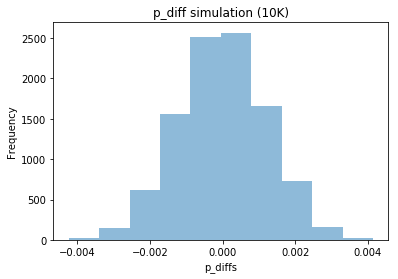

In [30]:
# places the values of 'p_diffs' in a numpy array
p_diffs = np.array(p_diffs)

# plots a histogram with a transparency of 0.5
plt.hist(p_diffs, alpha = 0.5)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('p_diff simulation (10K)');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# calculates the observed difference using the values from...
# ...part 1 section 4b. and 4c.
# con_conversion = control page converts
# treat_conversion = treatment page converts

# legacy code (now deprecated):
#obs_diff = (df2.query('group == "control"')['converted'].mean() -\
#            df2.query('group == "treatment"')['converted'].mean())

obs_diff = (con_conversion - treat_conversion)
print(obs_diff)

0.00157823898536


<a id='1'></a>

In [32]:
# p-value calculation; see below

# Legacy code, now deprecated:
# #(null_vals > obs_diff).mean()

(p_diffs > obs_diff).mean()

0.098500000000000004

The proportion of the average number of **p_diff values** that are higher than the observed difference is **0.0985**.

In [33]:
# creates a distribution under the null hypothesis

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

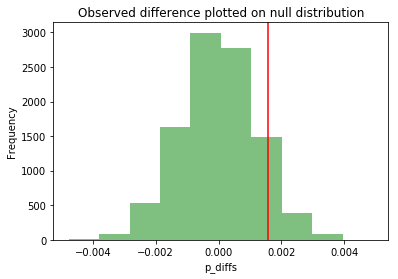

In [61]:
# plots the same graph above...

plt.hist(null_vals, color='green', alpha = 0.5)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Observed difference plotted on null distribution');

# adds a vertical line taken from the observed difference

plt.axvline(obs_diff, c='red');

The value calculated above is referred to as a **p-value**, a figure that helps gauge statistical evidence for or against the null hypothesis.

<ul>
    <li>a low p-value (<= 0.05) is indicative of strong support against the null hypothesis, culminating in the rejection of the null hypothesis  </li>
    <li>a high p-value (> 0.05) is indicative of strong support for the null hypothesis, culminating in the failure to reject the null hypothesis  </li></li>
</ul>

In the example above, the high p-value of <b>0.0985</b> indicates that we **would fail to reject the null hypothesis**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [35]:
# credit: https://bit.ly/2sWofn9
import statsmodels.api as sm

# Legacy code, now deprecated:
#convert_old = df2.query('group == "control"')['converted'].mean()
#convert_new = df2.query('group == "treatment"')['converted'].mean()

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# Legacy code, now deprecated:
#n_old = df2.query('group == "control"')['converted'].count()
#n_new = df2.query('group == "treatment"')['converted'].count()

n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

<a id='2'></a>

In [36]:
# added "alternative = 'smaller'" into the equation
# smaller suggests the null value is less than the hypothesis
# H0 < H1

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],\
                                              [n_old, n_new],\
                                             alternative = 'smaller')

print(z_score, p_value)

1.31092419842 0.905058312759


In [37]:
# credit: https://bit.ly/2sWofn9

from scipy.stats import norm

# Tells us how significant our z-score is
# is almost equal to the p-value calculated above

norm.cdf(z_score)

0.90505831275902449

In [38]:
# Tells us what our critical value at 95% confidence is

norm.ppf(1-(0.05/2))

1.959963984540054

Since the z-score of 0.90505831275902449 is below the critical value of 1.959963984540054, **we would fail to reject the null hypothesis**--much like the results from parts **j.** and **k.** above.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final section, we shall observe that the result acheived in the previous A/B test can also be replicated by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we shall use **logistic regression** in our analysis. Logistic regression is concerned with dichotomous variables like 0 and 1, which is suitable for an A/B test where we aim to understand whether someone converted (1) or not (0).

b. The goal is to use **statsmodels** to fit the logistic model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first we need to create a column for the intercept, and create a dummy variable column for which page each user received.  

To begin, we shall add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
# prints and overview of the df2 dataframe

df2.head(5)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [40]:
# adds a new column--intercept--into df2

df2['intercept'] = 1

# adds two new columns, control and treatment, into df2
# pd.get_dummies converts strings in 'groups' to ints
# result: control = 0, treatment = 1

df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

# view new columns and values therein

df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


In [41]:
# credit: https://bit.ly/2JzHx8Y

# renames the treatment column to 'ab_page'

df2.rename(index=str, columns={"treatment": "ab_page"}, inplace = True)
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1


In [42]:
# since we know treatment is 1, and control is 0...
# we can keep the ab_page column and drop 'control'

# removes the 'control' column, inplace for permanence

df2.drop('control', axis = 1, inplace = True)
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


In [43]:
# creates 2 new columns: 'new_page' and 'old_page'
# converts strings in 'landing_page' to binary 0 and 1s...
# places these 0s and 1s into the 2 new columns

df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0


c. Below we instantiate and fit the model, using the two columns created in part **b.** to predict whether or not an individual converts. 

A summary is also computed to help with A/B analysis.

In [44]:
# computes the logit model
# stores it in 'logit_mod'

logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

# the model is further computed and stored in 'results'

results = logit_mod.fit()

# the summary() function then provides and overview

results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:01:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [45]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [46]:
(1 / np.exp(results.params))

intercept    7.306593
ab_page      1.015102
dtype: float64

<a id='3'></a>

e. The p-value associated with **ab_page** in the summary above is **0.190** 

In section 2, the p_value was reported differently because it was derived from a one-tailed test (that is, does it move to the left or right of 0) using the formula:

$H_0: p_{new} - p_{old} \leq 0$

$H_1: p_{new} - p_{old} > 0$

In our regression analysis, the formula is akin to:

$H_0: p_{new} - p_{old} = 0$

$H_1: p_{new} - p_{old} \neq 0$

The p-value is therefore different since it is reporting on a different kind of relationship between 0 and non-0.

f. **An observation:** the unutilized timestamp column could be used to derive information like the average time of page conversion and particular days of the weeks that might have influenced the result.

With this said, adding additional data points could certainly introduce complexity that may increase the margin of error e.g. how do you account for regional time differences (especially in the US that has multiple time zones)?

g. A possible area of enquiry would be to ascertain whether conversion rate changes for different pages are dependent on which country a user lives in.

To begin, we shall import the **countries.csv dataset and merge it together with the df3 dataframe**--as expressed below:

In [47]:
# import 'countries.csv' and store it in...
# the variable 'countries'

countries = pd.read_csv('countries.csv')

countries.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [48]:
# verify the countries in the data set

countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [49]:
# values are listed alphabetically by default

# split country strings and convert them into binary 0s and 1s
# add them into the 'countires' dataframe under three new columns

countries[['CA', 'UK', 'US']] = pd.get_dummies(countries['country'])
countries.head(5)

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [50]:
# drop the redundant 'country' column from the dataframe

countries.drop('country', axis = 1, inplace = True)

countries.head(1)

,user_id,CA,UK,US
0,834778,0,1,0


In [51]:
# credit: https://bit.ly/2LBgV8j

# merge 'df3' and 'countries' via 'user_id'

df3 = pd.merge(df2, countries, on='user_id')

df3.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,0,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,1,0,0


In [52]:
df3.tail(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page,CA,UK,US
290579,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,0,1,0,0,1
290580,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,0,1,0,0,1
290581,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,1,0,0,1
290582,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,0,1,0,0,1
290583,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,0,1,0,0,1


In [53]:
# instantiate and fit model
# truncate 'US' to create matrices that are full rank

logit_mod1 = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'CA',\
                                            'UK']])

results1 = logit_mod1.fit()

# print summary

results1.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        10:01:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [54]:
# calculates the exponential of values in 'results1'

np.exp(results1.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

<u>**Findings**</u>

For every one point increase in the UK, an individual is 1.00 times more likely to convert, holding all other variables constant.

For every one point increase in Canada, an individual is 0.960 times more likely to convert, holding all other variables constant.

For every one point increase in ab_page, an individual is 0.985 times more likely to convert, holding all other variables constant.

There is a slight increase in conversion rates from users in the UK, but it is not large enough to be significant when compared to the other values.

In [55]:
# calculates the inverse exponential of values...
# ...in 'results1'

(1 / np.exp(results1.params))

intercept    7.310207
ab_page      1.015056
CA           1.041599
UK           0.990165
dtype: float64

h. Having looked at the individual factors of country and page on conversion, we will now look at ***an interaction between page and country*** to see if there are significant effects on conversion. 

In [56]:
# an interaction is created by multiplying two variables by one another
# in this example, we are multiplying 'new_page' with 'CA' to create 'CA_npage'

df3['CA_npage'] = df3['new_page'] * df3['CA']
df3['UK_npage'] = df3['new_page'] * df3['UK']

In [57]:
# instantiate and fit the model

logit_mod2 = sm.Logit(df3['converted'],\
                      df3[['intercept','new_page',\
                           'CA_npage','UK_npage']])

results2 = logit_mod2.fit()

# print the summary from results2

results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               3.351e-05
Time:                        10:01:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0183      0.013     -1.449      0.147      -0.043       0.006
CA_npage      -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK_npage       0.0257      0.019      1.363      0.173      -0.011       0.063
==============================================================================
"""

In [58]:
np.exp(results2.params)

intercept    0.136863
new_page     0.981901
CA_npage     0.937618
UK_npage     1.025986
dtype: float64

In [59]:
(1 / np.exp(results2.params))

intercept    7.306593
new_page     1.018432
CA_npage     1.066532
UK_npage     0.974672
dtype: float64

<u>**Findings**</u>

For every one point increase in CA_npage, an individual is 0.938 times more likely to convert, holding all other variables constant.

For every one point increase in UK_npage, an individual is 1.026 times more likely to convert, holding all other variables constant.

There is a slight increase in conversion rates from users in the UK, but it is not large enough to be significant when compared to the Canadian value (CA_npage).

<u>**Concluding thoughts**</u>

Despite a relatively large population of users having been exposed to the tests, it is recommended that the company continue the A/B test to assess whether a larger sample could help the company reach a firmer conclusion as to whether they should reject/fail to reject the null hypothesis.

<a id='creds'></a>
### Resources and credits ###

<ul>
  <li>Regression - https://bit.ly/2Ju5JOd</li>
  <li>Z tests - https://bit.ly/2Jz6Ls4</li>
  <li>Critical values and p values - https://bit.ly/2t1FL9M</li>
    <li>Stackoverflow resources - denoted by <i>'credit'</i> in comments</li>
  <li>And of course... the excellent feedback of the reviewer!</li>
</ul>